*Capstone Project - the battle of Neighborhoods*



Description of the question:

A restaurant business owner want to open a brand new restaurant in the city of Toronto. Nevertheless, he has no idea which area and type of restaurant he should choose. Therefore, he approached us to give him an analysis of the popular type of restaurant in the area, especially on different type of target customers.



In [5]:
!pip install bs4
! conda install -c conda-forge folium=0.5.0 --yes


     |████████████████████████████████| 122kB 16.6MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.1
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    attrs-21.2.0               |     pyhd8ed1ab_0          44 KB  conda-forge
    branca-0.4.2               |     pyhd8ed1ab_0          26 KB  conda-forge
    c

In [6]:
import pandas as pd 
from bs4 import BeautifulSoup 
import requests
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import folium 
from pandas.io.json import json_normalize

In [7]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

data = requests.get(url).text
soup = BeautifulSoup(data,"html5lib")
tables=soup.find_all('table')


In [8]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)
        
# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})


In [9]:
!wget -O Geospatial_Coordinates.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv


--2021-07-11 03:27:44--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2788 (2.7K) [text/csv]
Saving to: ‘Geospatial_Coordinates.csv’

Geospatial_Coordina 100%[===================>]   2.72K  --.-KB/s    in 0s      

2021-07-11 03:27:44 (60.6 MB/s) - ‘Geospatial_Coordinates.csv’ saved [2788/2788]



In [10]:
GC = pd.read_csv('Geospatial_Coordinates.csv')
GC = GC.rename(columns={'Postal Code':'PostalCode'})

In [11]:
df2= df[['PostalCode','Borough','Neighborhood']]
Df = df2.join(GC.set_index('PostalCode'), on='PostalCode')
Df

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto Business,Enclave of M4L,43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


In [12]:
CLIENT_ID = 'DM3LHY40QI2BNPJDCJZL41YKBEMVQFBSXJ055GAFCCHHKAK3'
CLIENT_SECRET = 'LCTNREXAVBTIDE2TEEXIKDHQ0FPGXOAEVDAYXO3BNZEF2QT2' 
VERSION = '20180605'
LIMIT = 200 
radius = 500

Define function that gets a specific section(category) in the Foursquare API

In [13]:
def getNearbyVenues(names, latitudes,longitudes,section, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):

        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&section={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,section)

        results = requests.get(url).json()["response"]['groups'][0]['items']

        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
Df_restaurants= getNearbyVenues(Df['Neighborhood'],Df['Latitude'],Df['Longitude'],'food')
print(Df_restaurants.shape)

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

In [20]:
Df_restaurants.to_csv('Df_restaurants.csv',index=False)

In [15]:
Df_restaurants = pd.read_csv('Df_restaurants.csv')
print(Df_restaurants.shape)

Df_restaurants.head()

(1633, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
1,Parkwoods,43.753259,-79.329656,Bella Vita Catering & Private Chef Service,43.756651,-79.331524,BBQ Joint
2,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
3,Victoria Village,43.725882,-79.315572,The Frig,43.727051,-79.317418,French Restaurant
4,Victoria Village,43.725882,-79.315572,Pizza Nova,43.725824,-79.312860,Pizza Place


In [17]:
print(Df_restaurants['Venue Category'].unique())
len(Df_restaurants['Venue Category'].unique())

['Fast Food Restaurant' 'BBQ Joint' 'Portuguese Restaurant'
 'French Restaurant' 'Pizza Place' 'Restaurant' 'Greek Restaurant'
 'Bakery' 'Breakfast Spot' 'Café' 'Sandwich Place' 'Food Truck'
 'Mexican Restaurant' 'Asian Restaurant' 'Italian Restaurant'
 'Seafood Restaurant' 'Thai Restaurant' 'Japanese Restaurant'
 'Sushi Restaurant' 'Chinese Restaurant' 'Vietnamese Restaurant'
 'Hot Dog Joint' 'Burger Joint' 'Persian Restaurant' 'Diner'
 'Burrito Place' 'Salad Place' 'Middle Eastern Restaurant' 'Wings Joint'
 'Fried Chicken Joint' 'Vegetarian / Vegan Restaurant' 'Deli / Bodega'
 'Creperie' 'Indian Restaurant' 'Caribbean Restaurant' 'Korean Restaurant'
 'Gastropub' 'Falafel Restaurant' 'Modern European Restaurant'
 'Steakhouse' 'Ramen Restaurant' 'Ethiopian Restaurant'
 'New American Restaurant' 'Mediterranean Restaurant' 'Poutine Place'
 'Food Court' 'Halal Restaurant' 'Filipino Restaurant'
 'Dim Sum Restaurant' 'Snack Place' 'American Restaurant'
 'Molecular Gastronomy Restaurant' 'Ge

94

Use one hot encoding

In [18]:
Df_restaurants_onehot = pd.get_dummies(Df_restaurants[['Venue Category']],prefix="", prefix_sep="")
Df_restaurants_onehot['Neighborhood'] = Df_restaurants['Neighborhood']
Df_restaurants_onehot = Df_restaurants_onehot[ ['Neighborhood'] + [ col for col in Df_restaurants_onehot.columns if col != 'Neighborhood' ] ]
Df_restaurants_onehot.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,...,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
Df_restaurants_onehot.shape

(1633, 95)

In [57]:
Df_restaurants_grouped = Df_restaurants_onehot.groupby('Neighborhood').sum().reset_index()
Df_restaurants_grouped

,Neighborhood,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,...,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Agincourt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Alderwood, Long Branch",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Bathurst Manor, Wilson Heights, Downsview North",0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,Bayview Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Bedford Park, Lawrence Manor East",0,1,0,0,0,0,0,0,0,...,2,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,Willowdale South,0,0,0,0,0,0,0,0,0,...,2,0,0,0,1,0,0,0,1,0
89,Willowdale West,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
90,Woburn,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
91,Woodbine Heights,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
Top_restaurant = pd.get_dummies(Df_restaurants[['Venue Category']],prefix="", prefix_sep="").sum(0)
Top_20_Types = Top_restaurant.sort_values(ascending=False)[:21]

Text(0, 0.5, 'Number of restaurants')

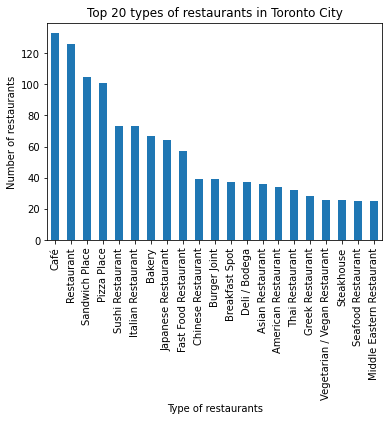

In [22]:
Top_20_Types.plot(kind='bar')
plt.title('Top 20 types of restaurants in Toronto City')
plt.xlabel('Type of restaurants')
plt.ylabel('Number of restaurants')

In [137]:
Df_restaurants_grouped2 =Df_restaurants_grouped
Df_restaurants_grouped2['Total'] = Df_restaurants_grouped.sum(axis=1)

Text(0.5, 0, 'Number of restaurants')

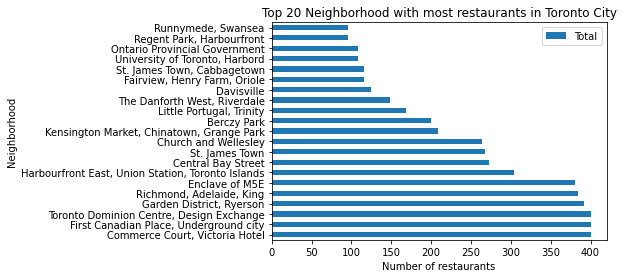

In [145]:
Df3 =Df_restaurants_grouped2[['Neighborhood','Total']].sort_values(by=['Total'], ascending=False)[:21].reset_index(drop=True)
Df3 = Df3.set_index('Neighborhood')
Df3.plot(kind='barh')
plt.title('Top 20 Neighborhood with most restaurants in Toronto City')
plt.ylabel('Neighborhood')
plt.xlabel('Number of restaurants')

Let's get the top 10 types of restaurants in each neighborhood 

In [23]:
def return_most_common_venues(row,num_top_venues):
        row_categories = row.iloc[1:]
        row_categories_sorted = row_categories.sort_values(ascending=False)
        return row_categories_sorted.index.values[0:num_top_venues]

In [72]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_restaurants_sorted = pd.DataFrame(columns=columns)
neighborhoods_restaurants_sorted['Neighborhood'] = Df_restaurants_grouped['Neighborhood']

for ind in np.arange(Df_restaurants_grouped.shape[0]):
    neighborhoods_restaurants_sorted.iloc[ind, 1:] = return_most_common_venues(Df_restaurants_grouped.iloc[ind, :], num_top_venues)

print(neighborhoods_restaurants_sorted.shape)
neighborhoods_restaurants_sorted.head()

(93, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Breakfast Spot,Chinese Restaurant,Latin American Restaurant,Filipino Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant
1,"Alderwood, Long Branch",Pizza Place,Burger Joint,Sandwich Place,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Pizza Place,Deli / Bodega,Fried Chicken Joint,Diner,Chinese Restaurant,Restaurant,Sushi Restaurant,Sandwich Place,Middle Eastern Restaurant,Eastern European Restaurant
3,Bayview Village,Japanese Restaurant,Chinese Restaurant,Café,Wings Joint,Fast Food Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
4,"Bedford Park, Lawrence Manor East",Pizza Place,Italian Restaurant,Sushi Restaurant,Restaurant,Sandwich Place,Comfort Food Restaurant,Café,Fast Food Restaurant,Japanese Restaurant,Breakfast Spot


In [51]:
Df_restaurants_grouped_mean = Df_restaurants_onehot.groupby('Neighborhood').mean().reset_index()
Df_restaurants_grouped_clustering = Df_restaurants_grouped_mean.drop('Neighborhood', 1)


Cluster the Neighborhood in to groups.
Check the best number of cluster to use

Text(0.5, 1.0, 'Elbow Method to Optimize K')

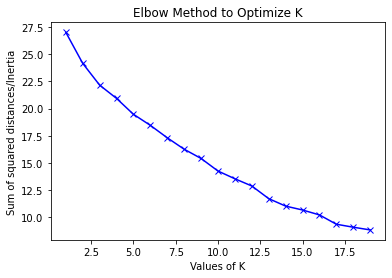

In [54]:


Sum_of_squared_distances = []
K = range(1,20)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(Df_restaurants_grouped_clustering)
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Sum of squared distances/Inertia')
plt.title('Elbow Method to Optimize K')

It looks like the elbow happened in K equals to 16

In [55]:
kclusters = 16
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Df_restaurants_grouped_clustering)

kmeans.labels_[0:10] 


array([ 0,  2,  0,  0,  0,  7, 15,  7,  1,  3], dtype=int32)

In [73]:
neighborhoods_restaurants_sorted.insert(0, 'Cluster Labels', kmeans.labels_)


Df_merged = Df
Df_merged = Df_merged.join(neighborhoods_restaurants_sorted.set_index('Neighborhood'),on='Neighborhood')


In [84]:
Df_merged = Df_merged.dropna(subset=['Cluster Labels'])
Df_merged['Cluster Labels']=Df_merged['Cluster Labels'].astype(int)
print(Df_merged.shape)
Df_merged.head()

(93, 16)


,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,4,BBQ Joint,Fast Food Restaurant,Wings Joint,Filipino Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
1,M4A,North York,Victoria Village,43.725882,-79.315572,15,Portuguese Restaurant,Pizza Place,French Restaurant,Falafel Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,7,Café,Bakery,Restaurant,Sandwich Place,Breakfast Spot,Sushi Restaurant,Seafood Restaurant,Chinese Restaurant,Japanese Restaurant,Italian Restaurant
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,7,Vietnamese Restaurant,Hot Dog Joint,Filipino Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,0,Sushi Restaurant,Diner,Burger Joint,Chinese Restaurant,Japanese Restaurant,Italian Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Deli / Bodega,Sandwich Place


Now let's examine the population data of Toronto and see which neighborhoods had the most population density

In [37]:
url_popdata = 'https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Tables/CompFile.cfm?Lang=Eng&T=1201&OFT=FULLCSV'

popdata = pd.read_csv(url_popdata)

popdata = popdata[['Geographic code','Geographic name','Province or territory','Population, 2016']]
popdata =popdata[popdata['Province or territory']== "Ontario"]
popdata['Population, 2016'].astype(float)

650     103474.0
651      20945.0
652      52154.0
653      38903.0
654      37097.0
          ...   
1168      1942.0
1169     10048.0
1170      5002.0
1171     10651.0
1172     14009.0
Name: Population, 2016, Length: 523, dtype: float64

In [146]:
popdata.describe()

,"Population, 2016"
count,523.000000
mean,25714.133843
std,18796.480831
min,0.000000
25%,13082.000000
50%,21722.000000
75%,34287.500000
max,111372.000000


Let's visualize the population distribution of neighborhood in Toronto on a map

In [43]:
!wget --quiet toronto_m.geojson https://github.com/BlizzWiz/IBM_Capstone_Project/raw/master/toronto_m.geojson

In [46]:
to_geo= r'toronto_m.geojson'
    
a = folium.Map(location=[43.64, -79.37], zoom_start=11)

a.choropleth(
    geo_data= to_geo,data= popdata,
    columns=['Geographic code','Population, 2016'],
    key_on='feature.properties.CFSAUID',
    fill_color='Blues',
    fill_opacity=0.9, 
    line_opacity=0.1,
    legend_name='Population of Toronto by FSAs')
a

Add markers to the map indicating neighborhoods clustered by restaurants

In [85]:
x= np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0,1,len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors=[]
for lat, lon, poi, cluster in zip(Df_merged['Latitude'],Df_merged['Longitude'], Df_merged['Neighborhood'],Df_merged['Cluster Labels']):
    label = folium.Popup(str(poi)+' Cluster '+ str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat,lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(a)
a

let's examine top 3 clusters with most number of neighborhoods

In [98]:
for k in range(kclusters):
    print('Cluster ',k,'has ',list(kmeans.labels_).count(k),'values')

Cluster  0 has  20 values
Cluster  1 has  2 values
Cluster  2 has  6 values
Cluster  3 has  4 values
Cluster  4 has  8 values
Cluster  5 has  1 values
Cluster  6 has  1 values
Cluster  7 has  30 values
Cluster  8 has  3 values
Cluster  9 has  1 values
Cluster  10 has  1 values
Cluster  11 has  1 values
Cluster  12 has  1 values
Cluster  13 has  1 values
Cluster  14 has  2 values
Cluster  15 has  11 values


Cluster 7 in lightblue color dots

In [100]:
Df_merged.loc[Df_merged['Cluster Labels']==7,Df_merged.columns[[2]+list(range(6,Df_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"Regent Park, Harbourfront",Café,Bakery,Restaurant,Sandwich Place,Breakfast Spot,Sushi Restaurant,Seafood Restaurant,Chinese Restaurant,Japanese Restaurant,Italian Restaurant
3,"Lawrence Manor, Lawrence Heights",Vietnamese Restaurant,Hot Dog Joint,Filipino Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant
11,"West Deane Park, Princess Gardens, Martin Grov...",Filipino Restaurant,Bakery,Middle Eastern Restaurant,Fast Food Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
13,Don Mills South,Restaurant,Asian Restaurant,Chinese Restaurant,Italian Restaurant,Sushi Restaurant,Sandwich Place,Dim Sum Restaurant,Café,Wings Joint,Ethiopian Restaurant
14,Woodbine Heights,Diner,BBQ Joint,Café,Snack Place,Wings Joint,Fast Food Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
15,St. James Town,Restaurant,Café,Italian Restaurant,Sushi Restaurant,Diner,Breakfast Spot,Bakery,Gastropub,Seafood Restaurant,Moroccan Restaurant
18,"Guildwood, Morningside, West Hill",Breakfast Spot,Donut Shop,Restaurant,Mexican Restaurant,Fast Food Restaurant,Diner,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
20,Berczy Park,Bakery,Restaurant,Sandwich Place,Italian Restaurant,Sushi Restaurant,Diner,Steakhouse,Café,Seafood Restaurant,Bistro
25,Christie,Café,Italian Restaurant,Restaurant,Wings Joint,Fast Food Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
26,Cedarbrae,Hakka Restaurant,Thai Restaurant,Fried Chicken Joint,Caribbean Restaurant,Bakery,Wings Joint,Fast Food Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant


Cluster 0 in deep red color dots

In [99]:
Df_merged.loc[Df_merged['Cluster Labels']==0,Df_merged.columns[[2]+list(range(6,Df_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Ontario Provincial Government,Sushi Restaurant,Diner,Burger Joint,Chinese Restaurant,Japanese Restaurant,Italian Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Deli / Bodega,Sandwich Place
7,Don Mills North,Fried Chicken Joint,Japanese Restaurant,Korean Restaurant,Caribbean Restaurant,Sandwich Place,Café,Wings Joint,Falafel Restaurant,Doner Restaurant,Donut Shop
9,"Garden District, Ryerson",Café,Restaurant,Pizza Place,Japanese Restaurant,Fast Food Restaurant,Sandwich Place,Burger Joint,Middle Eastern Restaurant,Sushi Restaurant,Chinese Restaurant
23,Leaside,Sushi Restaurant,Pizza Place,Sandwich Place,Burger Joint,Breakfast Spot,Middle Eastern Restaurant,Mexican Restaurant,Restaurant,Fish & Chips Shop,Peking Duck Restaurant
24,Central Bay Street,Café,Sandwich Place,Italian Restaurant,Chinese Restaurant,Japanese Restaurant,Pizza Place,Restaurant,Fast Food Restaurant,Deli / Bodega,Middle Eastern Restaurant
28,"Bathurst Manor, Wilson Heights, Downsview North",Pizza Place,Deli / Bodega,Fried Chicken Joint,Diner,Chinese Restaurant,Restaurant,Sushi Restaurant,Sandwich Place,Middle Eastern Restaurant,Eastern European Restaurant
33,"Fairview, Henry Farm, Oriole",Fast Food Restaurant,Restaurant,Japanese Restaurant,Bakery,Chinese Restaurant,Food Court,Asian Restaurant,Pizza Place,Deli / Bodega,Burger Joint
39,Bayview Village,Japanese Restaurant,Chinese Restaurant,Café,Wings Joint,Fast Food Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
47,"India Bazaar, The Beaches West",Pizza Place,Sandwich Place,Fast Food Restaurant,Burrito Place,Steakhouse,Restaurant,Italian Restaurant,Fish & Chips Shop,Sushi Restaurant,Eastern European Restaurant
48,"Commerce Court, Victoria Hotel",Sandwich Place,Café,Restaurant,Italian Restaurant,Asian Restaurant,Deli / Bodega,American Restaurant,Japanese Restaurant,Pizza Place,Bakery


Cluster 15 in light red color dots

In [101]:
Df_merged.loc[Df_merged['Cluster Labels']==15,Df_merged.columns[[2]+list(range(6,Df_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Victoria Village,Portuguese Restaurant,Pizza Place,French Restaurant,Falafel Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
8,"Parkview Hill, Woodbine Gardens",Pizza Place,Gastropub,Café,Breakfast Spot,German Restaurant,Fried Chicken Joint,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant
10,Glencairn,Pizza Place,Asian Restaurant,Japanese Restaurant,Bakery,Sushi Restaurant,Wings Joint,Fast Food Restaurant,Diner,Doner Restaurant,Donut Shop
17,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",Pizza Place,Fried Chicken Joint,Café,Deli / Bodega,Wings Joint,Falafel Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant
31,"Dufferin, Dovercourt Village",Bakery,Portuguese Restaurant,Middle Eastern Restaurant,Brazilian Restaurant,Café,Pizza Place,Wings Joint,Ethiopian Restaurant,Diner,Doner Restaurant
34,"Northwood Park, York University",Vietnamese Restaurant,Falafel Restaurant,Caribbean Restaurant,Pizza Place,German Restaurant,Gastropub,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant
35,The Danforth East,Greek Restaurant,Pizza Place,Bakery,Fast Food Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
50,Humber Summit,Pizza Place,Colombian Restaurant,Restaurant,Falafel Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
58,"Birch Cliff, Cliffside West",Mediterranean Restaurant,Japanese Restaurant,Café,Pizza Place,Fried Chicken Joint,French Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant
63,"Runnymede, The Junction North",Breakfast Spot,Caribbean Restaurant,Pizza Place,German Restaurant,Falafel Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Gluten-free Restaurant


Create 3 maps with choropleth, indicating the concetration of schools, offices and resdiences. In addition, neighborhoods with clusters denoted in colours are put on top of the map.

In [ ]:
map_clusters_school = folium.Map(location=[43.653559, -79.361809], zoom_start=11)

Toronto_geo = r'toronto_crs84.geojson'

map_clusters_school.choropleth(
    geo_path=Toronto_geo,
    data=School_count,
    columns=p)


In [ ]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    if len(categories_list) ==0:
        return None
    else:
        return categories_list[0]['name']